In [105]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#匯入資料集
from tensorflow.keras.datasets import boston_housing
#切分特徵、目標
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

#正規化&標準化
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

#建立模型
from keras import layers
from keras import metrics
import keras.backend as K

def build_model():
    model = keras.Sequential([
        # 隱藏層 1
        layers.Dense(128, activation="relu"),
        # 隱藏層 2
        layers.Dense(64, activation="relu"),
        # 隱藏層 3
        layers.Dense(64, activation="relu"),
        # 輸出層
        layers.Dense(1)
    ])

    def mape(y_true, y_pred):
        return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

    model.compile(optimizer="rmsprop", loss="mse", metrics=[metrics.MAE, mape, metrics.RootMeanSquaredError()])

    return model

**因為資料集較小，需要K-Fold驗證**

In [106]:
# 導入所需模組
from tensorflow.keras import layers

# 定義 k 的值
k = 4

# 計算每個驗證集樣本數量
num_val_samples = len(train_data) // k

# 定義訓練的 epochs 數量
num_epochs = 100

# 用於儲存每個 fold 的模型評估指標（這裡是 MAE）
all_scores = []

# 迴圈執行 k 次交叉驗證
for i in range(k):
     # 列印正在處理的 fold 編號
     print(f"Processing fold #{i}")

     # 從原始資料中劃分出驗證集資料和標籤
     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

     # 建立部分訓練資料集（將目前 fold 以外的所有資料合併起來）
     partial_train_data = np.concatenate(
         [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立部分訓練標籤（將目前 fold 以外的所有標籤合併）
     partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立神經網路模型（假設在其他地方已定義 build_model() 函數）
     model = build_model()

     # 在部分訓練資料上訓練模型
     model.fit(partial_train_data, partial_train_targets,
               epochs=num_epochs, batch_size=16, verbose=0)

     # 在驗證集上評估模型，取得 MAE 值
     val_loss_and_metrics = model.evaluate(val_data, val_targets, verbose=0)
     val_mae = val_loss_and_metrics[1] # 取得 MAE 值
     all_scores.append(val_mae) # 將 MAE 值加入到清單中

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**儲存每次fold紀錄**

In [107]:
# 定義訓練的 epochs 數量
num_epochs = 500

# 用於儲存每個 fold 的 MAE 歷史記錄
all_mae_histories = []

# 迴圈執行 k 次交叉驗證
for i in range(k):
     # 列印正在處理的 fold 編號
     print(f"Processing fold #{i}")

     # 從原始資料中劃分出驗證集資料和標籤
     val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
     val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

     # 建立部分訓練資料集（將目前 fold 以外的所有資料合併起來）
     partial_train_data = np.concatenate(
         [train_data[:i * num_val_samples],
          train_data[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立部分訓練標籤（將目前 fold 以外的所有標籤合併）
     partial_train_targets = np.concatenate(
         [train_targets[:i * num_val_samples],
          train_targets[(i + 1) * num_val_samples:]],
         axis=0)

     # 建立神經網路模型
     model = build_model()

     # 在部分訓練資料上訓練模型，並記錄訓練過程中的 MAE 歷史
     history = model.fit(partial_train_data, partial_train_targets,
                         validation_data=(val_data, val_targets),
                         epochs=num_epochs, batch_size=16, verbose=0)

     # 取得每個 epoch 的驗證集 MAE 值，儲存到 all_mae_histories 中
     mae_history = history.history["val_mean_absolute_error"]
     all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


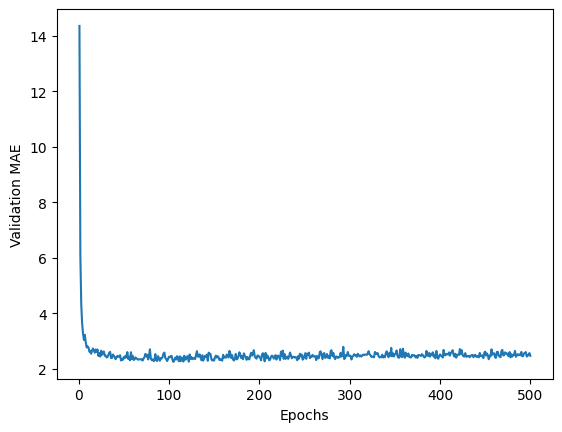

In [108]:
#繪製圖表
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [109]:
test_scores = model.evaluate(test_data, test_targets)
print(test_scores)

4/4 [==============================] - 0s 4ms/step - loss: 13.1359 - mean_absolute_error: 2.6546 - mape: 14.1505 - root_mean_squared_error: 3.6243
[13.135905265808105, 2.6545870304107666, 14.150506019592285, 3.6243488788604736]


In [110]:
# 训练最終模型
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=32, verbose=0)

# 使用 model.evaluate() 取得测试集的指标值
test_scores = model.evaluate(test_data, test_targets)

# 使用 model.evaluate() 取得训练集的指标值
train_scores = model.evaluate(train_data, train_targets)

# 列印训练集的指标值
print("Train Loss:", train_scores[0])
print("Train MAE:", train_scores[1])
print("Train MAPE:", train_scores[2])
print("Train RMSE:", train_scores[3])
print("----------------------------------")
# 列印测试集的指标值
print("Test Loss:", test_scores[0])
print("Test MAE:", test_scores[1])
print("Test MAPE:", test_scores[2])
print("Test RMSE:", test_scores[3])



13/13 [==============================] - 0s 2ms/step - loss: 2.7786 - mean_absolute_error: 1.1814 - mape: 6.0817 - root_mean_squared_error: 1.6669
Train Loss: 2.7785825729370117
Train MAE: 1.181416630744934
Train MAPE: 6.08167839050293
Train RMSE: 1.6669081449508667
----------------------------------
Test Loss: 13.107380867004395
Test MAE: 2.3982908725738525
Test MAPE: 14.021417617797852
Test RMSE: 3.6204116344451904


In [111]:
# 設定要列印的行數
num_rows_to_print = 10

# 使用訓練好的模型對測試集進行預測
predictions = model.predict(test_data)

# 列印實際值和預測值
print("實際值\t\t預測值")
for i in range(num_rows_to_print):
    print(f"{test_targets[i]}\t{predictions[i][0]}")

4/4 [==============================] - 0s 3ms/step
實際值		預測值
7.2	7.011476516723633
18.8	18.37640953063965
19.0	21.360017776489258
27.0	35.256004333496094
22.2	24.103778839111328
24.5	23.050600051879883
31.2	28.113964080810547
22.9	20.228384017944336
20.5	19.06671142578125
23.2	20.639345169067383
